In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import colour
import cv2

In [2]:
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [3]:
def decrease_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    lim = value
    v[v < lim] = 0
    v[v >= lim] -= value
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR, cv2.CV_8U)
    return img

In [4]:
def cluster(image, clusters):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image_array = image.reshape((image.shape[0]*image.shape[1], 3))
    clf = MiniBatchKMeans(n_clusters = clusters, batch_size = 4096)
    labels = clf.fit_predict(image_array)
    quantized = clf.cluster_centers_.astype("uint8")[labels].reshape((image.shape[0], image.shape[1], 3))
    return cv2.cvtColor(quantized, cv2.COLOR_LAB2BGR, cv2.CV_8U)

In [5]:
def cluster_brightened(image, clusters, lighten_value, darken_value):
    return decrease_brightness(cluster(increase_brightness(image, lighten_value), clusters), darken_value)

In [28]:
def standardise_colours(quantized_image):
    assigned_colours = np.array([[[0,128,0],[128,0,0],[64,64,64]]], np.uint8)
    assigned_colours = cv2.cvtColor(assigned_colours, cv2.COLOR_BGR2LAB)
    quantized_image = cv2.cvtColor(quantized_image, cv2.COLOR_BGR2LAB)
    unique_colours = np.unique(quantized_image.reshape(-1, 3), axis = 0)
    for i in assigned_colours[0]:
        max_value = 1000000000
        map_colour = 0
        for j in unique_colours:
            if(colour.delta_E(i,j) < max_value):
                max_value = colour.delta_E(i,j)
                map_colour = j
        quantized_image[np.any(quantized_image == map_colour, axis=-1)] = i
    quantized_image = cv2.cvtColor(quantized_image, cv2.COLOR_LAB2BGR, cv2.CV_8U)
    return quantized_image

In [10]:
img = cv2.imread("image_0.png", cv2.IMREAD_UNCHANGED)
img1 = img.copy()
img1[np.any(img1 == [0,0,0,0], axis=-1)] = [255,255,255,255]
img2 = cv2.cvtColor(img1, cv2.COLOR_RGBA2BGR)

img1[np.any(img1 != [255,255,255,255], axis=-1)] = [0,0,0,0]
img3 = cv2.cvtColor(img1, cv2.COLOR_RGBA2BGR)

img4 = cluster_brightened(img2, 4, 100, 75)
img5 = standardise_colours(img4)
img5[np.any(img3==[255,255,255], axis=-1)] = [255,255,255]
np.unique(img5.reshape((img5.shape[0] * img5.shape[1], 3)), axis = 0)

array([[  0, 128,   0],
       [ 53,  55,  53],
       [128,   2,   0],
       [179, 179, 179],
       [255, 255, 255]], dtype=uint8)

In [12]:
def test(img_url):
    img = cv2.imread(img_url, cv2.IMREAD_UNCHANGED)
    img[np.any(img==[0,0,0,0], axis=-1)] = [255,255,255,255]
    img2 = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    

img = cv2.imread("image_1.png", cv2.IMREAD_UNCHANGED)
img1 = img.copy()
img1[np.any(img1 == [0,0,0,0], axis=-1)] = [255,255,255,255]
img2 = cv2.cvtColor(img1, cv2.COLOR_RGBA2BGR)

img1[np.any(img1 != [255,255,255,255], axis=-1)] = [0,0,0,0]
img3 = cv2.cvtColor(img1, cv2.COLOR_RGBA2BGR)

img4 = cluster_brightened(img2, 4, 100, 75)
img5 = standardise_colours(img4)
img5[np.any(img3==[255,255,255], axis=-1)] = [255,255,255]
np.unique(img5.reshape((img5.shape[0] * img5.shape[1], 3)), axis = 0)

array([[  0, 128,   0],
       [ 50,  50,  50],
       [128,   2,   0],
       [180, 181, 178],
       [255, 255, 255]], dtype=uint8)

[[  0   0   0]
 [255 255 255]]
[[  0 128   0]
 [128   2   0]
 [255 255 255]]


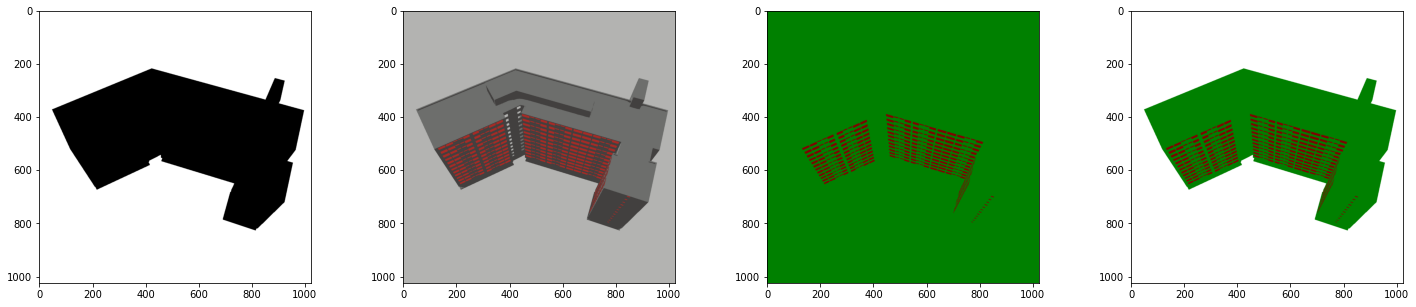

In [33]:
img = cv2.imread("image_2.png", cv2.IMREAD_UNCHANGED)
img1 = img.copy()
img1[np.any(img1 == [0,0,0,0], axis=-1)] = [255,255,255,255]
img2 = cv2.cvtColor(img1, cv2.COLOR_RGBA2BGR)

img1[np.any(img1 != [255,255,255,255], axis=-1)] = [0,0,0,0]
img3 = cv2.cvtColor(img1, cv2.COLOR_RGBA2BGR)

fig, axes = plt.subplots(1,4, figsize=(25, 5))
axes[0].imshow(img3)

img4 = cluster_brightened(img2, 4, 100, 75)
axes[1].imshow(img4)
img5 = standardise_colours(img4)
axes[2].imshow(img5)
print(np.unique(img3.reshape(-1,3), axis=0))
img5[np.any(img3==[255,255,255], axis=-1)] = [255,255,255]
axes[3].imshow(img5)
print(np.unique(img5.reshape(-1,3), axis=0))

(1024, 1024, 4)

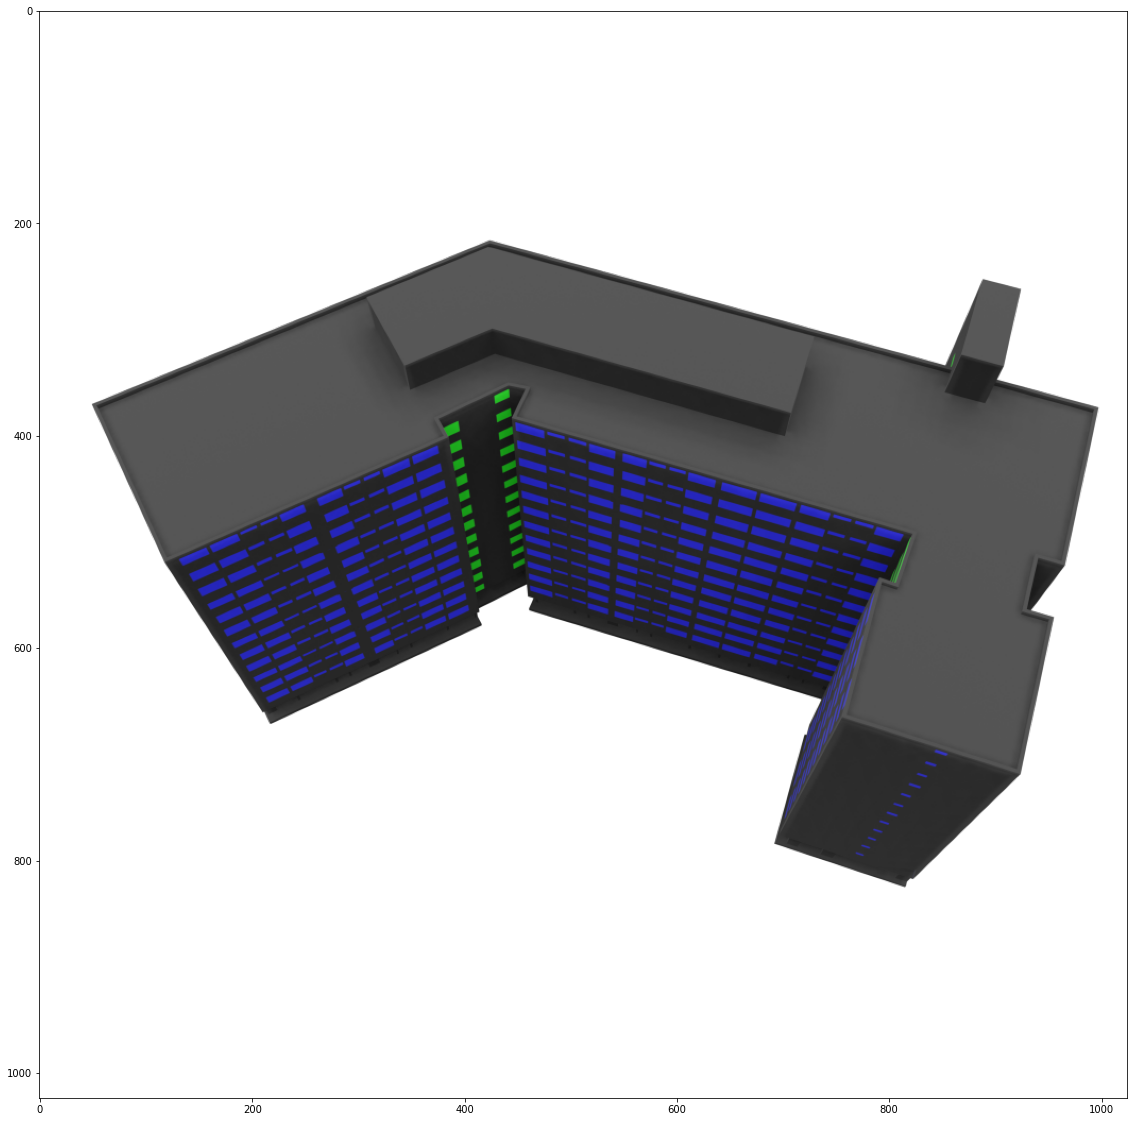

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(img)
img.shape

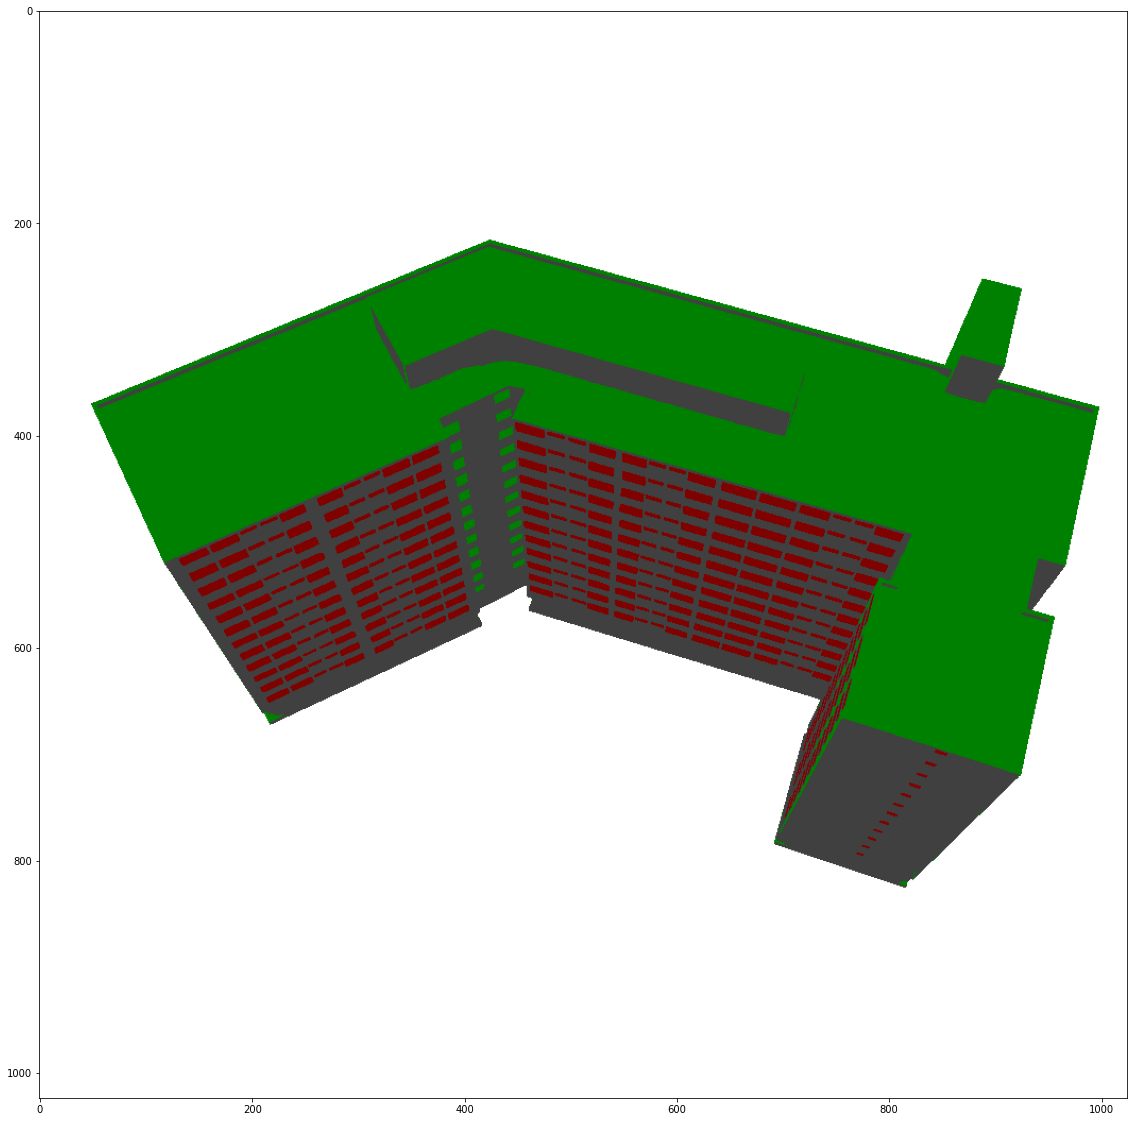

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(img5)

In [8]:
def cluster_test(clustering_function, lighten_value, darken_value, images):
    fig, axes = plt.subplots(len(images),3,figsize=(9,10))
    for i in range(len(images)):
        image = cv2.imread(images[i])
        quantized_image = clustering_function(image, 4, lighten_value, darken_value)
        standardised_image = standardise_colours(quantized_image)
        axes[i, 0].imshow(image)
        axes[i, 1].imshow(quantized_image)
        axes[i, 2].imshow(standardised_image)
    fig.tight_layout()
    plt.show()

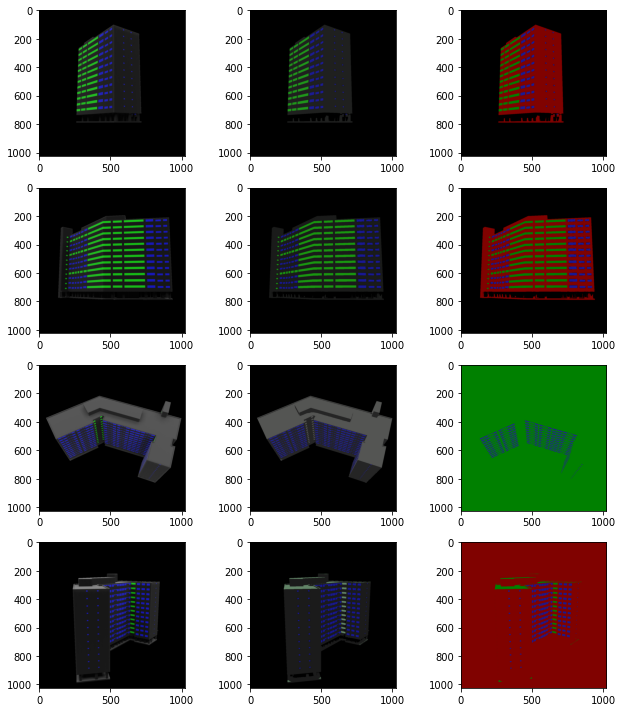

In [9]:
cluster_test(cluster_brightened, 100, 100, [])